In [30]:
import os
import pandas as pd

# We'll store the debug data in a global variable so you can reuse it without re-reading.
DEBUG_DATA = None

def load_mosaic_debug_csv():
    """
    Loads the mosaic_full_debug_log.csv file (written by your updated debug code) from ~/Downloads,
    converts relevant columns to numeric, and filters for rays that reached the detector 
    (EventType == 'intersection-detector', IntersectionDetector == 'True').

    Returns:
        A pandas DataFrame with columns like:
            'IntersectionDetector', 'EventType', 'H', 'K', 'L', 'Qx', 'Qy', 'Qz', 'Val'
    """
    csv_path = os.path.expanduser("~/Downloads/mosaic_full_debug_log.csv")
    if not os.path.isfile(csv_path):
        raise FileNotFoundError(f"CSV file not found at {csv_path}")

    # Read CSV into a DataFrame
    df = pd.read_csv(csv_path)

    # For clarity, let's print the columns that we have:
    print("Columns in debug CSV:", df.columns.tolist())

    # Filter for intersection-detector events (you can adjust this as needed)
    df = df[df["EventType"] == "intersection-detector"]

    # Convert 'IntersectionDetector' to string and check for 'True'
    df["IntersectionDetector"] = df["IntersectionDetector"].astype(str).str.lower()
    df = df[df["IntersectionDetector"] == "true"]

    # Convert Qx, Qy, Qz, and Val to numeric (if present)
    for col in ["Qx", "Qy", "Qz", "Val"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Drop rows with NaNs in Qx, Qy, Qz
    df.dropna(subset=["Qx", "Qy", "Qz"], inplace=True)

    return df

# Actual load step
DEBUG_DATA = load_mosaic_debug_csv()

print("Loaded debug CSV into DEBUG_DATA.")
print(f"Total valid rows: {len(DEBUG_DATA)}")

# Print a quick summary of Q-range
if "Qx" in DEBUG_DATA.columns:
    print(f"Qx range: [{DEBUG_DATA['Qx'].min():.3e}, {DEBUG_DATA['Qx'].max():.3e}]")
if "Qy" in DEBUG_DATA.columns:
    print(f"Qy range: [{DEBUG_DATA['Qy'].min():.3e}, {DEBUG_DATA['Qy'].max():.3e}]")
if "Qz" in DEBUG_DATA.columns:
    print(f"Qz range: [{DEBUG_DATA['Qz'].min():.3e}, {DEBUG_DATA['Qz'].max():.3e}]")

# Show the first few rows to confirm structure
DEBUG_DATA.head(10)


Columns in debug CSV: ['Timestamp', 'EventType', 'IntersectionDetector', 'H', 'K', 'L', 'Qx', 'Qy', 'Qz', 'Val']
Loaded debug CSV into DEBUG_DATA.
Total valid rows: 17034624
Qx range: [-3.632e+00, 3.777e+00]
Qy range: [-2.521e+00, 1.459e-01]
Qz range: [4.528e-07, 4.106e+00]


,Timestamp,EventType,IntersectionDetector,H,K,L,Qx,Qy,Qz,Val
0,2025-03-06T13:29:35.389457,intersection-detector,true,0,0,3,0.656078,-0.051466,0.014221,3.846636e-63
1,2025-03-06T13:29:35.389457,intersection-detector,true,0,0,3,0.656065,-0.052564,0.010247,1.123658e-63
2,2025-03-06T13:29:35.389457,intersection-detector,true,0,0,3,0.656026,-0.053662,0.006274,3.267228e-64
3,2025-03-06T13:29:35.389457,intersection-detector,true,0,0,3,0.655961,-0.054760,0.002301,9.456262e-65
4,2025-03-06T13:29:35.389457,intersection-detector,true,0,0,3,-0.656029,-0.053953,0.002078,8.819517e-65
5,2025-03-06T13:29:35.389457,intersection-detector,true,0,0,3,-0.656093,-0.052855,0.006051,3.048016e-64
6,2025-03-06T13:29:35.389457,intersection-detector,true,0,0,3,-0.656132,-0.051757,0.010024,1.048539e-63
7,2025-03-06T13:29:35.389457,intersection-detector,true,0,0,3,-0.656145,-0.050659,0.013998,3.590411e-63
8,2025-03-06T13:29:35.389457,intersection-detector,true,0,0,3,-0.656132,-0.049561,0.017972,1.223754e-62
9,2025-03-06T13:29:35.389457,intersection-detector,true,0,0,3,-0.656093,-0.048463,0.021945,4.151753e-62


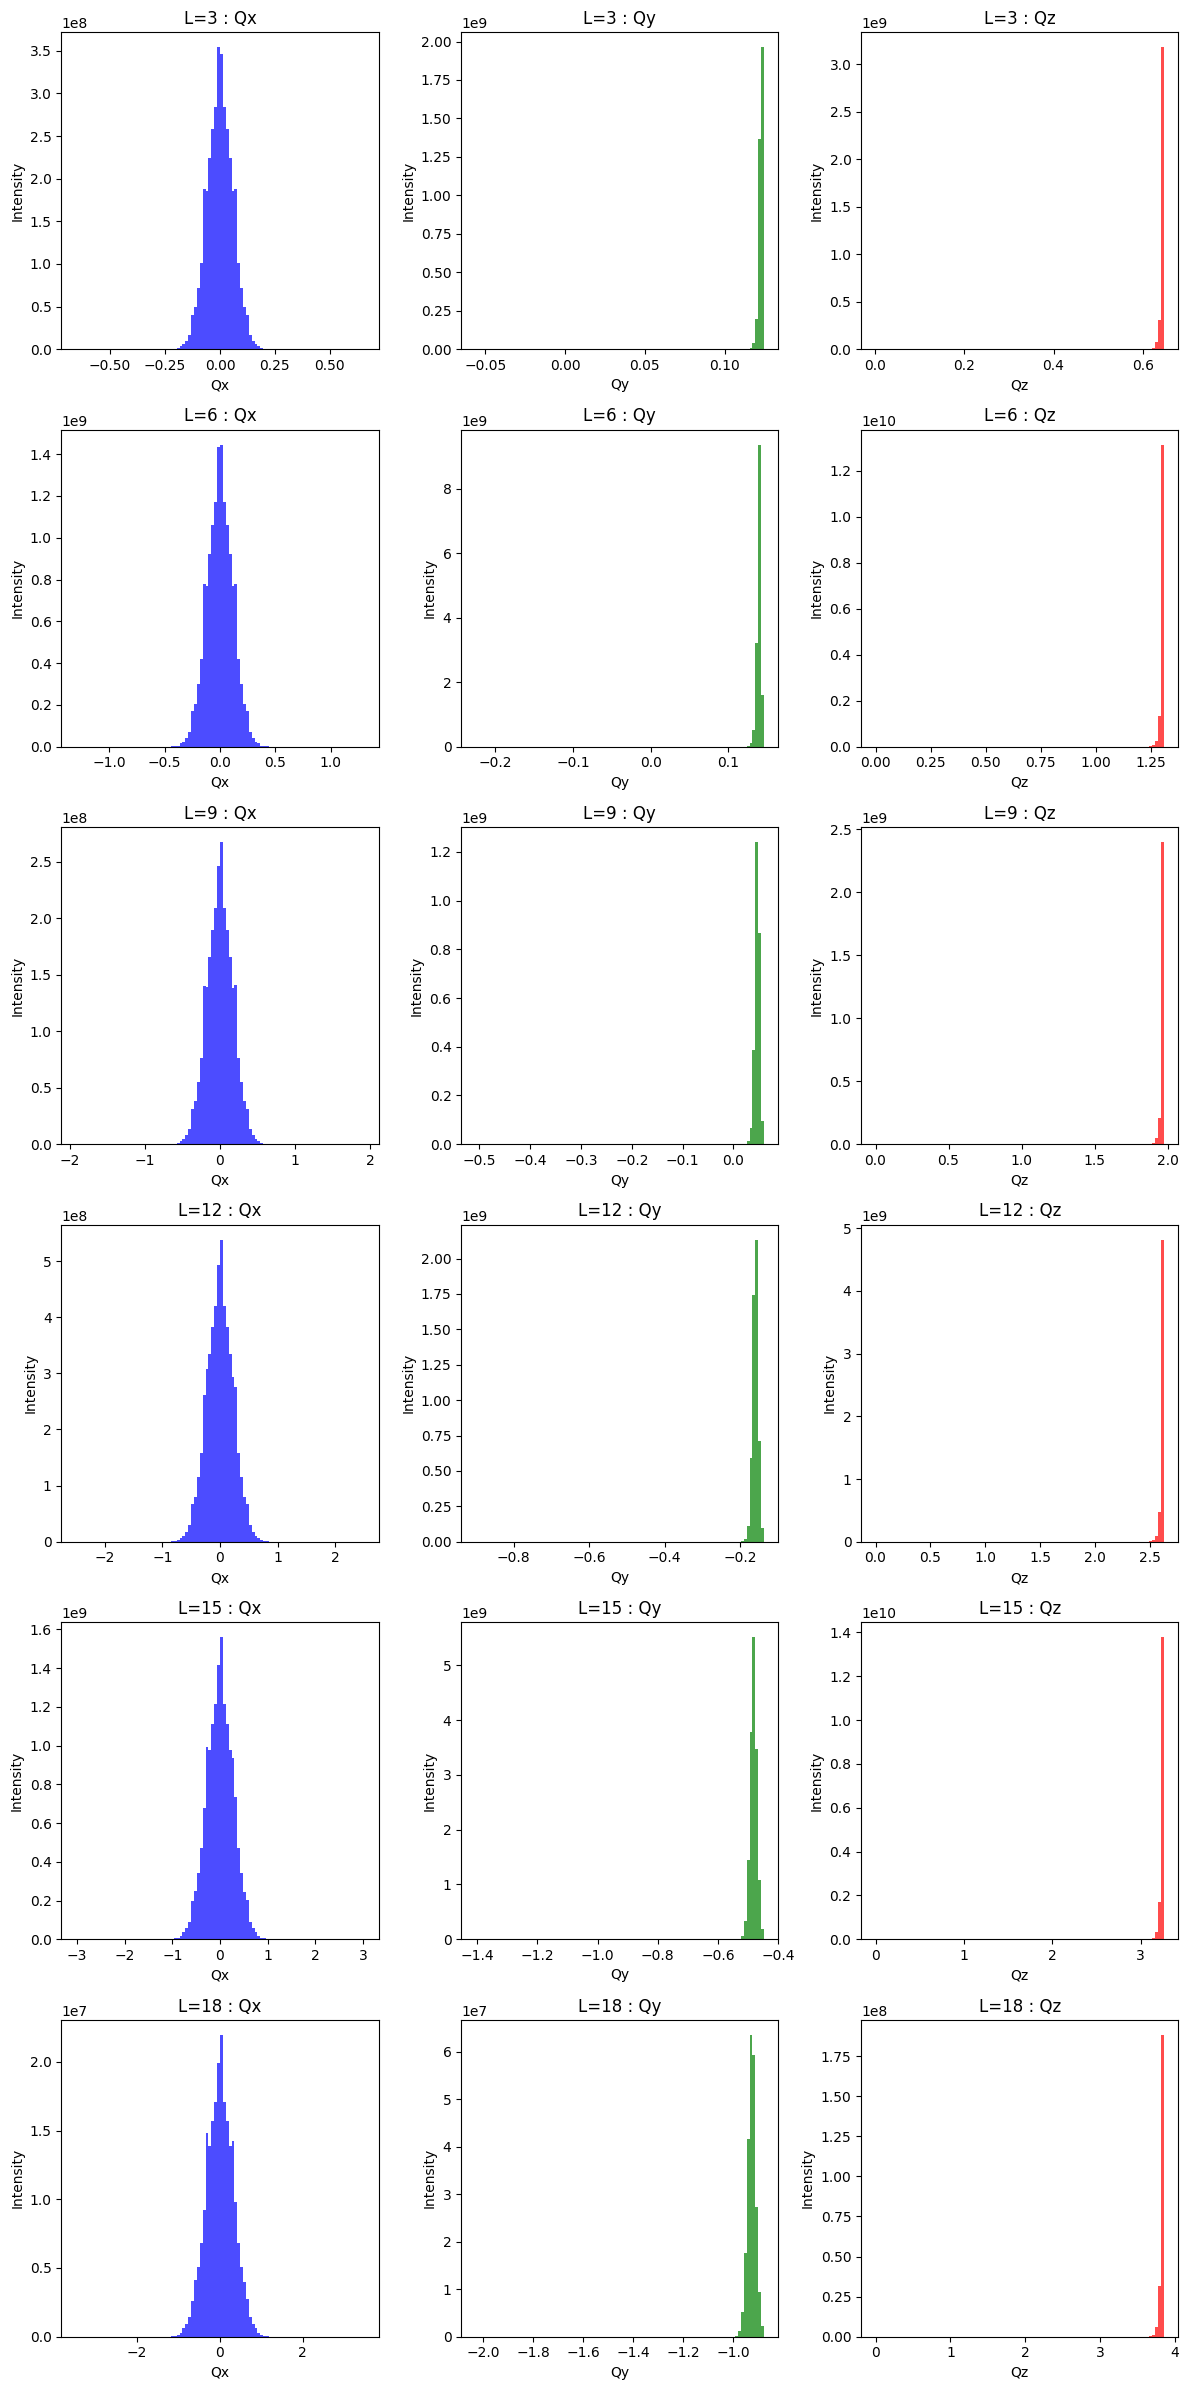

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histograms_for_hk0_by_L(df):
    """
    In one figure, creates 3 histograms (Qx, Qy, Qz) for each unique L
    where H=0 and K=0. Instead of counting occurrences, the histograms
    display the summed intensity in each bin, using the 'Val' column as weights.

    Parameters:
      df (DataFrame): Must contain columns 'H', 'K', 'L', 'Qx', 'Qy', 'Qz', and 'Val'.
    """
    # 1) Filter for H=0, K=0
    df_hk0 = df[(df["H"] == 0) & (df["K"] == 0)]
    if df_hk0.empty:
        print("No rows found with H=0 and K=0. Nothing to plot.")
        return

    # 2) Find every unique L
    unique_L = sorted(df_hk0["L"].unique())
    n_L = len(unique_L)

    # 3) Create one row (3 subplots) per L: one for Qx, one for Qy, one for Qz
    fig, axes = plt.subplots(nrows=n_L, ncols=3, figsize=(12, 4 * n_L))
    if n_L == 1:
        axes = np.array([axes])  # ensure axes is 2D

    for i, Lval in enumerate(unique_L):
        df_L = df_hk0[df_hk0["L"] == Lval]

        # Qx histogram with intensity weights in column 0
        axes[i, 0].hist(df_L["Qx"], bins=100, weights=df_L["Val"], color="blue", alpha=0.7)
        axes[i, 0].set_xlabel("Qx")
        axes[i, 0].set_ylabel("Intensity")
        axes[i, 0].set_title(f"L={Lval} : Qx")

        # Qy histogram with intensity weights in column 1
        axes[i, 1].hist(df_L["Qy"], bins=100, weights=df_L["Val"], color="green", alpha=0.7)
        axes[i, 1].set_xlabel("Qy")
        axes[i, 1].set_ylabel("Intensity")
        axes[i, 1].set_title(f"L={Lval} : Qy")

        # Qz histogram with intensity weights in column 2
        axes[i, 2].hist(df_L["Qz"], bins=100, weights=df_L["Val"], color="red", alpha=0.7)
        axes[i, 2].set_xlabel("Qz")
        axes[i, 2].set_ylabel("Intensity")
        axes[i, 2].set_title(f"L={Lval} : Qz")

    plt.tight_layout()
    plt.show()

# Example usage:
# Assume that 'DEBUG_DATA' is a DataFrame with columns 'H', 'K', 'L', 'Qx', 'Qy', 'Qz', and 'Val'.
plot_histograms_for_hk0_by_L(DEBUG_DATA)


In [ ]:
import plotly.express as px
import plotly.io as pio
import numpy as np

pio.renderers.default = "browser"

def plot_3d_q_space_with_sampling(df, sample_size=100000, marker_size=2, intensity_threshold=1000):
    """
    Plots a 3D scatter of Qx, Qy, Qz from df, sampling to sample_size rows.
    - Points are colored by the intensity ('Val') associated with each point.
    - Only points with intensity >= intensity_threshold are plotted.
    - Intensity values are capped so that any value above 2e5 becomes 2e5.
    - Uses a color scale (viridis) that is friendly for color blind viewers.
    - marker_size controls the appearance of the points.

    Args:
      df (pandas.DataFrame): Must contain columns 'Qx', 'Qy', 'Qz', and 'Val'.
      sample_size (int): The number of rows to sample for plotting.
      marker_size (int or float): Marker size for each point.
      intensity_threshold (float): Minimum intensity value required to plot a point.
    """
    # Filter out points with intensity below the threshold.
    df_filtered = df[df["Val"] >= intensity_threshold].copy()
    if df_filtered.empty:
        print(f"No points found with intensity >= {intensity_threshold}. Nothing to plot.")
        return

    # Cap the intensity values: any value above 2e5 becomes 2e5.
    df_filtered["Val"] = np.minimum(df_filtered["Val"], 2e5)

    n_rows = len(df_filtered)
    if n_rows > sample_size:
        df_plot = df_filtered.sample(n=sample_size, random_state=42)
        print(f"Dataset of {n_rows} rows sampled down to {sample_size}.")
    else:
        df_plot = df_filtered
        print(f"Dataset has {n_rows} rows, no sampling needed.")

    fig = px.scatter_3d(
        df_plot,
        x="Qx",
        y="Qy",
        z="Qz",
        color="Val",  # Color by intensity.
        color_continuous_scale="viridis",  # Viridis is colorblind-friendly.
        title="3D Scatter of Sampled Q Points (Colored by Capped Intensity)"
    )
    fig.update_layout(
        scene=dict(
            xaxis_title="Qx",
            yaxis_title="Qy",
            zaxis_title="Qz"
        ),
        width=800,
        height=700
    )
    fig.update_traces(marker=dict(size=marker_size))
    fig.show()

# Usage example:
plot_3d_q_space_with_sampling(DEBUG_DATA, sample_size=500000, marker_size=2)


Dataset of 5954783 rows sampled down to 500000.
